In [1]:
# initializations & configurations
# create spark sessions
import os
import pyspark
from pyspark.sql.functions import *
from datetime import datetime

conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/05 17:17:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [2]:
# data sanitation
df=spark.read.csv("dummy.csv", header=True)
df1=df.filter(col('HS')=='1')
df2=df.filter(col('HS')=='0')
df=df1.union(df2)
df.show(5)

+---+--------------------+---+---+---+
| id|                text| HS| TR| AG|
+---+--------------------+---+---+---+
|201|Hurray, saving us...|  1|  0|  0|
|202|Why would young f...|  1|  0|  0|
|203|@KamalaHarris Ill...|  1|  0|  0|
|206|@KurtSchlichter L...|  1|  0|  0|
|212|@RealDonaldTrump ...|  1|  0|  1|
+---+--------------------+---+---+---+
only showing top 5 rows



In [3]:
# general dataset info
df_category=df.groupBy("HS").count().show()

+---+-----+
| HS|count|
+---+-----+
|  1|  390|
|  0|  590|
+---+-----+



In [4]:
df=df.withColumn('cleaned', regexp_replace(lower(col('text')), '[^a-z0-9\s]', ''))
df.show(5)

+---+--------------------+---+---+---+--------------------+
| id|                text| HS| TR| AG|             cleaned|
+---+--------------------+---+---+---+--------------------+
|201|Hurray, saving us...|  1|  0|  0|hurray saving us ...|
|202|Why would young f...|  1|  0|  0|why would young f...|
|203|@KamalaHarris Ill...|  1|  0|  0|kamalaharris ille...|
|206|@KurtSchlichter L...|  1|  0|  0|kurtschlichter le...|
|212|@RealDonaldTrump ...|  1|  0|  1|realdonaldtrump h...|
+---+--------------------+---+---+---+--------------------+
only showing top 5 rows



In [ ]:
! pip install yake

In [5]:
import yake
from pyspark.sql.functions import udf

In [6]:
# keyword extraction

language = "en"
max_ngram_size = 3
deduplication_threshold = 0.1
numOfKeywords = 8
ex=yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

def kw_extract(text, model=ex):
    keywords = model.extract_keywords(text)
    if len(keywords)>3:
        keywords=sorted(keywords, key=lambda x:x[1])[:3]
        keywords='~'.join([item[0] for item in keywords])
        return str(keywords)
    else:
        keywords='~'.join([item[0] for item in keywords])
        return str(keywords)
udf_extractor=udf(kw_extract)

df=df.withColumn('kw', split(udf_extractor(col('cleaned')), '~')).select('id', 'cleaned', 'kw', 'HS')

In [7]:
df.show()

+---+--------------------+--------------------+---+
| id|             cleaned|                  kw| HS|
+---+--------------------+--------------------+---+
|201|hurray saving us ...|[enddaca boycottn...|  1|
|202|why would young f...|[young fighting a...|  1|
|203|kamalaharris ille...|[nodaca noamnesty...|  1|
|206|kurtschlichter le...|[kurtschlichter l...|  1|
|212|realdonaldtrump h...|[realdonaldtrump ...|  1|
|216|lithuania romania...|[lithuania romani...|  1|
|217|worldbank reports...|[worldbank report...|  1|
|218|rich african coun...|[american countri...|  1|
|226|wattersworld jess...|[wattersworld jes...|  1|
|228|eus hailed migran...|[eus hailed migra...|  1|
|230|ms13 spreads to 2...|[murdersgopleader...|  1|
|234|the real truth is...|[real truth, colo...|  1|
|236|watch french mayo...|[watch french may...|  1|
|239|two children wash...|[barb wired beach...|  1|
|241|watch muslim migr...|[watch muslim mig...|  1|
|243|islam in europe d...|[african immigran...|  1|
|246|amymek 

In [12]:
# phrase frequency based on categories

df1=df.select('kw', 'HS').withColumn('kw', explode(col('kw')))
data1=df1.filter(col('HS')=='1').groupBy('kw').count().sort(col('count').desc()).head(10)
data0=df1.filter(col('HS')=='0').groupBy('kw').count().sort(col('count').desc()).head(10)

[Row(kw='back', count=10), Row(kw='dont', count=8), Row(kw='buildthatwall', count=8), Row(kw='trump', count=6), Row(kw='illegal', count=6), Row(kw='kids', count=5), Row(kw='ice', count=5), Row(kw='law', count=5), Row(kw='free speech time', count=5), Row(kw='wall', count=4)]


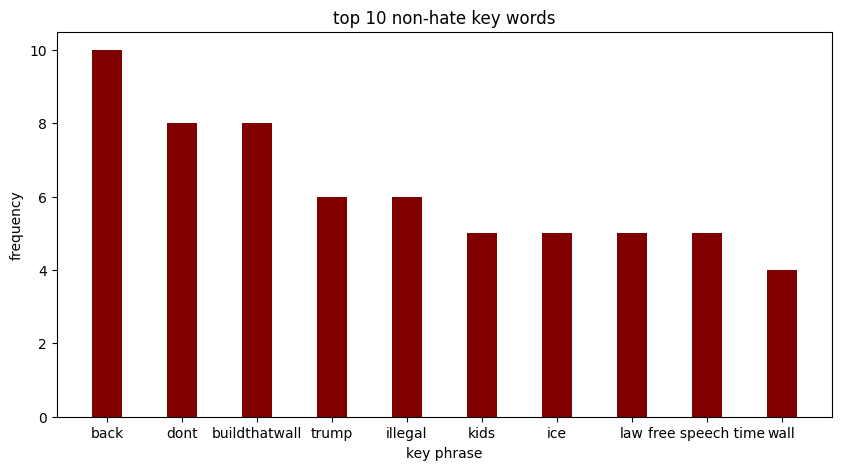

In [22]:
import matplotlib.pyplot as plt

x1, y1=list(zip(*data1))
x0, y0=list(zip(*data0))

fig = plt.figure(figsize = (10, 5))
plt.bar(x1, y1, color ='maroon', width = 0.4)
plt.xlabel("key phrase")
plt.ylabel("frequency")
plt.title("top 10 non-hate key words")
plt.show()

In [8]:
from pyspark.ml.feature import *

In [9]:
# word2vec

df1=df.select('kw', 'HS').withColumn('kw', explode(col('kw')))
df1=df1.withColumn('HS', regexp_replace(col('HS'), '0', '-1').cast('double'))
df_tend=df1.groupBy('kw').sum('HS')
df_count=df1.groupBy('kw').count()
df1=df_tend.join(df_count, 'kw', 'inner').withColumn('index', col('sum(HS)')/(col('count').cast('double')))
df1.show()

+--------------------+-------+-----+-------------------+
|                  kw|sum(HS)|count|              index|
+--------------------+-------+-----+-------------------+
|andrewscheer cpch...|    1.0|    1|                1.0|
|illegal trespasse...|    1.0|    1|                1.0|
|skynews leaveeuof...|    1.0|    1|                1.0|
|                 yrs|    0.0|    2|                0.0|
|illigal refugees ...|    1.0|    1|                1.0|
|  monitordeport visa|    1.0|    1|                1.0|
|gift trumpbots bu...|    1.0|    1|                1.0|
|eyes peeled promises|    1.0|    1|                1.0|
|             arguing|    1.0|    1|                1.0|
|open bordersdrain...|    1.0|    1|                1.0|
|                 amp|  -12.0|   14|-0.8571428571428571|
|tooedit numbersus...|    1.0|    1|                1.0|
|         white house|    1.0|    1|                1.0|
|      legal migrants|    1.0|    1|                1.0|
|illegal buildthat...|    1.0| 

In [10]:
# end of analysis for now

word2Vec = Word2Vec(vectorSize=5, seed=42, inputCol="kw", outputCol="vector")
word2Vec.setMaxIter(10)
word2Vec.getMaxIter()
word2Vec.clear(word2Vec.maxIter)
model = word2Vec.fit(df1)
model.getMinCount()
model.setInputCol("kw")
model.getVectors().show()

IllegalArgumentException: requirement failed: Column kw must be of type equal to one of the following types: [array<string>, array<string>] but was actually of type string.

In [14]:
sent = ("a b " * 100 + "a c " * 10).split(" ")
doc = spark.createDataFrame([(sent,), (sent,)], ["sentence"])
doc.show(truncate=True)
word2Vec = Word2Vec(vectorSize=5, seed=42, inputCol="sentence", outputCol="model")
word2Vec.setMaxIter(10)

word2Vec.getMaxIter()

word2Vec.clear(word2Vec.maxIter)
model = word2Vec.fit(doc)
model.getMinCount()

model.setInputCol("sentence")

model.getVectors().show()


+--------------------+
|            sentence|
+--------------------+
|[a, b, a, b, a, b...|
|[a, b, a, b, a, b...|
+--------------------+

+----+--------------------+
|word|              vector|
+----+--------------------+
|   a|[0.09511678665876...|
|   b|[-1.2028766870498...|
|   c|[0.30153277516365...|
+----+--------------------+

